In [924]:
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [925]:
logs = pd.read_json('logins.json')

## Part 1
Run EDA to visualize 15 min increments of the login data

In [926]:
logs['login_time'] = pd.to_datetime(logs['login_time'], format='%Y-%m-%d %H:%M:%S')

In [927]:
# datetime already
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [928]:
logs.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [929]:
# replace the index with the datetimes so resampling can be done
logs.set_index('login_time', inplace=True)

In [930]:
# create frequency column for logins initialized at 1 so they can be summed
logs['frequency'] = np.ones(len(logs))

In [931]:
# resample into 15min intervals
logs=logs.resample('15Min').sum()

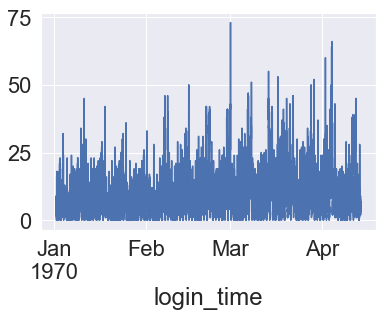

In [932]:
# quick plot reveals there are cyclical patterns, appearing to be weekly
logs['frequency'].plot();

In [933]:
# extract m/d by new column from index
logs['timestamp'] = pd.to_datetime(logs.index)
logs['month'] = logs['timestamp'].dt.month
logs['day'] = logs['timestamp'].dt.day
logs['weekday'] = logs['timestamp'].dt.weekday # Mon=0
logs['hour'] = logs['timestamp'].dt.hour

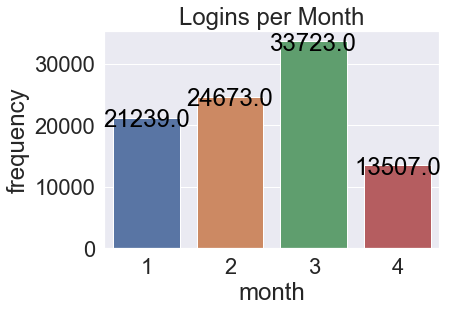

In [934]:
by_month = logs.groupby('month').sum()
ax=sns.barplot(by_month.index, by_month.frequency)
plt.title('Logins per Month')
for index, row in by_month.iterrows():
    ax.text(x=index-1, y=row.frequency-1500, s=row.frequency, color='black', ha='center') ;

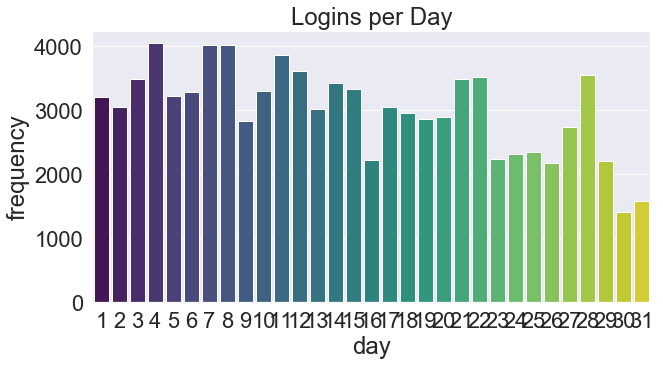

In [935]:
plt.figure(figsize=(10,5))
by_day = logs.groupby('day').sum()
sns.barplot(by_day.index, by_day.frequency, palette="viridis")
plt.title('Logins per Day');

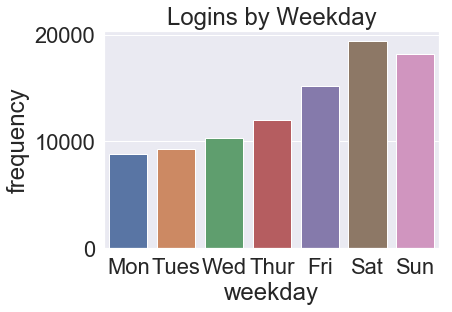

In [936]:
by_weekday = logs.groupby('weekday').sum()
ax=sns.barplot(by_weekday.index, by_weekday.frequency)
plt.title('Logins by Weekday')
ax.set(xticklabels=['Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

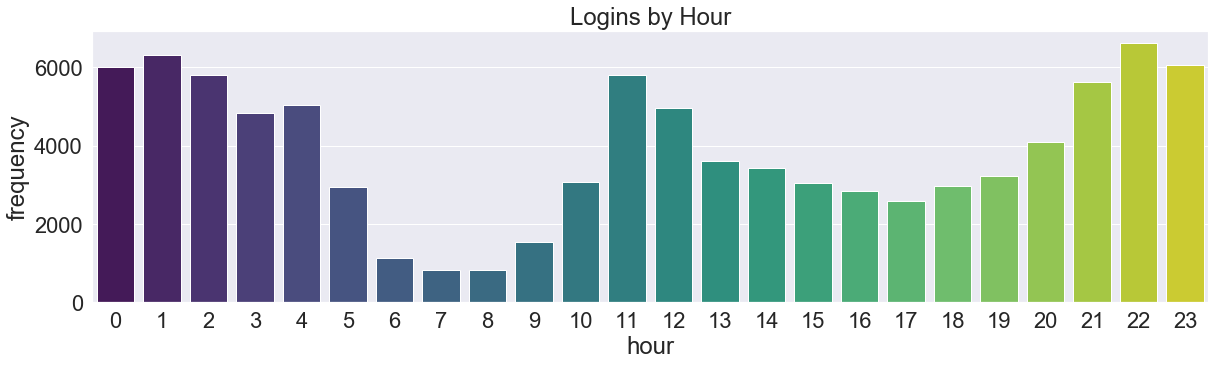

In [937]:
by_hour = logs.groupby('hour').sum()
plt.figure(figsize=(20,5))
sns.barplot(by_hour.index, by_hour.frequency, palette='viridis')
plt.title('Logins by Hour');

In [938]:
# drop y/m/d from timestamp to just get time
logs['time_of_day'] = logs['timestamp'].apply(lambda x: x.time())

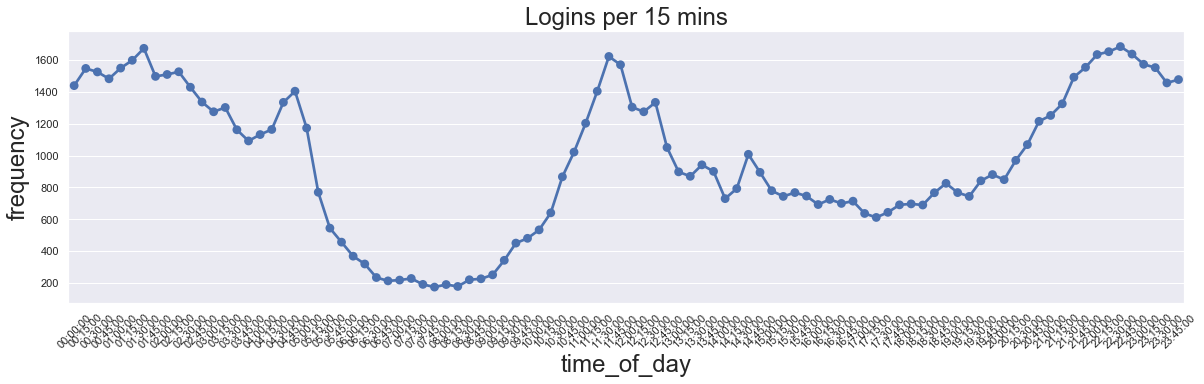

In [939]:
plt.figure(figsize=(20,5))
by_time = logs.groupby('time_of_day').sum()
ax=sns.pointplot(x=by_time.index, y=by_time.frequency)
plt.title('Logins per 15 mins')
ax.tick_params(labelsize=11)
plt.xticks(rotation=45);

It appears that user logins follow a distinc pattern:

    1) For hours: Bimodal, busy between 9am-4pm (while people are at work), and then again from 8pm-5am at night. 
    2) For weekdays: Fri, Sat, and Sun have the most logins.
    3) By day of the month: Slight decline through the month, however there were only 13 days recorded in April, cutting the 15-31 day counts by 1/4
    4) By month: Clearly shows a strong increasing trend. If records were to continue, I'd expect April to have the most 
    5) Per 15min intervals: Follows the trend nearly exactly as by hours, being bimodal.

## Part 2

In [940]:
with open('ultimate_data_challenge.json') as f:
    data = json.load(f)
df = pd.DataFrame.from_records(data)

### Key metric for success: 
Since the toll's are being reinmbursed, that should increase drive avg_dist (since traveling between cities is almost always going to be greater than distance within a single city). Since drivers are also going back and forth between the cities and the cities have near equivalent demand through the full day/week (just at different times), then the proposal would be successful if the number of passengers transported from one city to another is about equal (vs not, where drivers/passengers stay within their city).

### Practical experiment:
Conducting a hypothesis test will determine if the experiment was successful or not. 
    
    a) First, assess the activity of each driver and where they pick up the most passengers. Use that to label the driver as a driver of either Gotham or Metroplois. Find the amount of passengers from each city and split them up accordingly from before/after the instituted experiment. 
    b) Using the number of passengers in the hypothesis test to calculate the Z-statistic and compare the corresponding pvalue with a chosen significance level of a=0.05, I can reject or accept the null hypothesis.
    c) If the experiment is deemed a failure, look at potential reasons why and propose some change based on the information found

## Part 3

In [941]:
# about 18% of the rows have missing data, mostly in avg rating of/by driver, and some phone.
df[df.isnull().any(axis=1)].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
6,3.95,4.0,NaN,1.0,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0
9,2.37,5.0,NaN,1.0,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0
12,20.29,5.0,NaN,1.0,Winterfell,2014-03-12,iPhone,2014-01-15,0.0,1,False,100.0
14,26.01,5.0,NaN,1.0,Astapor,2014-01-28,Android,2014-01-27,0.0,1,False,100.0
15,13.20,5.0,NaN,1.0,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,True,100.0


In [942]:
# drop rows missing values to handle missing data
df=df.dropna()
df.reset_index(inplace=True)

In [943]:
# examine some features to better understand data
df.phone.value_counts()

iPhone     29352
Android    12093
Name: phone, dtype: int64

iPhone users appear to be about 2.5 times as prevalent as Android users

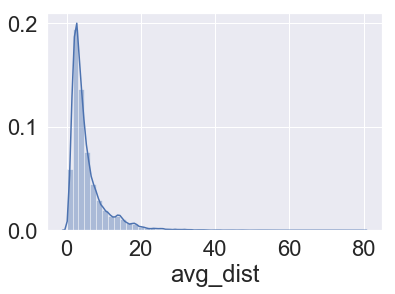

In [944]:
sns.distplot(df.avg_dist);

Avg distance is slightly right skewed with a mean of 5.5

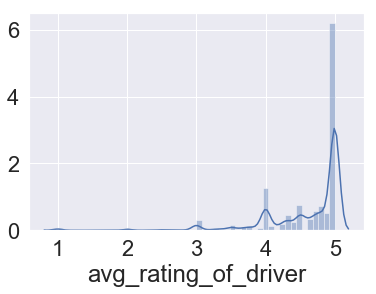

In [945]:
sns.distplot(df.avg_rating_of_driver);

Most drivers appear to receive 5 or 4 stars, with few lower than that.

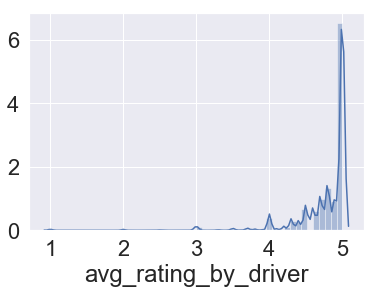

In [946]:
sns.distplot(df.avg_rating_by_driver);

Drivers appear to be more generous with ratings, giving out less 4 stars relative to 5

In [947]:
# convert to datetime object
df['signup_date'] = df['signup_date'].apply(lambda x: pd.Timestamp(x, tz=None))
df['last_trip_date'] = df['last_trip_date'].apply(lambda x: pd.Timestamp(x, tz=None))

In [948]:
# create retention metric. Data spans jan-1 through july-1, so use last month as retention check
df['retained'] = df['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-6-1', tz=None) else 0)

In [949]:
# measure retention rate
df.retained.value_counts()

0    24410
1    17035
Name: retained, dtype: int64

17035 of the 41445 total users are labeled as 'retained', which is about 41% and not amazing

In [950]:
# convert cats to binary
cities = df.city
df=pd.get_dummies(df, columns=['city', 'phone'])

In [951]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,index,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
index,1,-0.00392344,0.00550321,0.0120587,0.00122374,0.00261135,0.003481,-0.00122517,0.00612232,-0.000803171,0.000269796,0.0106057,-0.00894386,0.00539674,-0.00539674
avg_dist,-0.00392344,1,0.0831897,0.0348774,-0.0857496,-0.110894,-0.136471,0.0272057,0.102048,-0.0894981,-0.0417365,0.0256187,0.0182459,0.0251151,-0.0251151
avg_rating_by_driver,0.00550321,0.0831897,1,0.122413,0.0124175,0.0197027,-0.0457879,0.00570842,0.0183121,-0.0347196,0.0314877,0.0966473,-0.108795,0.0126384,-0.0126384
avg_rating_of_driver,0.0120587,0.0348774,0.122413,1,-0.022209,-0.00169607,-0.0118492,-0.00329215,0.0129748,-0.0118286,0.0329162,0.0893546,-0.104162,0.027327,-0.027327
avg_surge,0.00122374,-0.0857496,0.0124175,-0.022209,1,0.795737,-0.000262185,-0.0706129,-0.118999,-0.00418542,0.0357436,-0.00547845,-0.0291146,-0.013029,0.013029
surge_pct,0.00261135,-0.110894,0.0197027,-0.00169607,0.795737,1,0.00537031,-0.0998141,-0.155179,0.0111259,0.0447532,0.0368728,-0.0722872,-0.0145608,0.0145608
trips_in_first_30_days,0.003481,-0.136471,-0.0457879,-0.0118492,-0.000262185,0.00537031,1,0.115066,0.0555558,0.198816,-0.0631532,0.0181885,0.0444687,-0.0563667,0.0563667
ultimate_black_user,-0.00122517,0.0272057,0.00570842,-0.00329215,-0.0706129,-0.0998141,0.115066,1,0.033964,0.217365,0.0229875,0.0409859,-0.0551948,-0.0762712,0.0762712
weekday_pct,0.00612232,0.102048,0.0183121,0.0129748,-0.118999,-0.155179,0.0555558,0.033964,1,0.010423,-0.0110387,0.0331254,-0.0167649,-0.00406007,0.00406007
retained,-0.000803171,-0.0894981,-0.0347196,-0.0118286,-0.00418542,0.0111259,0.198816,0.217365,0.010423,1,-0.180322,0.25559,-0.0399022,-0.233722,0.233722


Cor plot shows high relation between avg surge and surge_pct, so drop one

In [952]:
# apply scaling to some values with large range of data
to_scale = ['avg_dist', 'surge_pct', 'weekday_pct']
df[to_scale] = df[to_scale].apply(lambda x: (x-x.mean())/x.std())

In [953]:
# split features
y=df.retained
X=df.drop(columns=['index', 'last_trip_date', 'signup_date', 'retained', 'avg_surge'])

In [954]:
#split data for train/test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

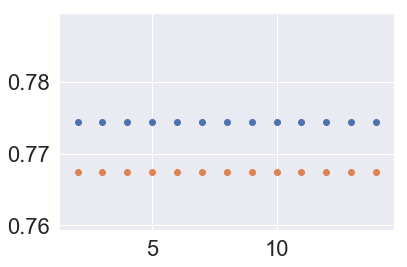

In [955]:
# test with random forest
rsqd_train=[]
rsqd_test=[]
variable=[]

for i in np.arange(2,15,1):
    classifier = RandomForestClassifier(n_estimators=10, max_depth=6, min_samples_split=8, random_state=42)
    classifier.fit(X_train, y_train)
    rsqd_train.append(classifier.score(X_train, y_train))
    rsqd_test.append(classifier.score(X_test, y_test))
    variable.append(i)
    
# use to adjust hyperperameters
plt.figure()
plt.scatter(variable, rsqd_train); # blue
plt.scatter(variable, rsqd_test); # orange

In [956]:
classifier = RandomForestClassifier(n_estimators=10, max_depth=6, min_samples_split=8, random_state=42)
classifier.fit(X_train, y_train)
y_prediction = classifier.predict(X_test)

In [957]:
print(confusion_matrix(y_test, y_prediction))
print('R^2 score:', classifier.score(X_test, y_test))
print(classification_report(y_test, y_prediction))

[[6119 1174]
 [1718 3423]]
R^2 score: 0.7674119350168892
              precision    recall  f1-score   support

           0       0.78      0.84      0.81      7293
           1       0.74      0.67      0.70      5141

   micro avg       0.77      0.77      0.77     12434
   macro avg       0.76      0.75      0.76     12434
weighted avg       0.77      0.77      0.77     12434



The model appears to classify retention pretty well, with an R^2 of 0.77 and f1-score of 0.7 for true positives

In [958]:
pd.Series(classifier.feature_importances_, index=X.columns).sort_values(ascending=False)

avg_rating_by_driver      0.207565
city_King's Landing       0.163353
weekday_pct               0.148801
surge_pct                 0.113403
trips_in_first_30_days    0.082248
ultimate_black_user       0.081623
phone_Android             0.061828
phone_iPhone              0.050600
avg_rating_of_driver      0.029701
city_Astapor              0.027768
city_Winterfell           0.020789
avg_dist                  0.012319
dtype: float64

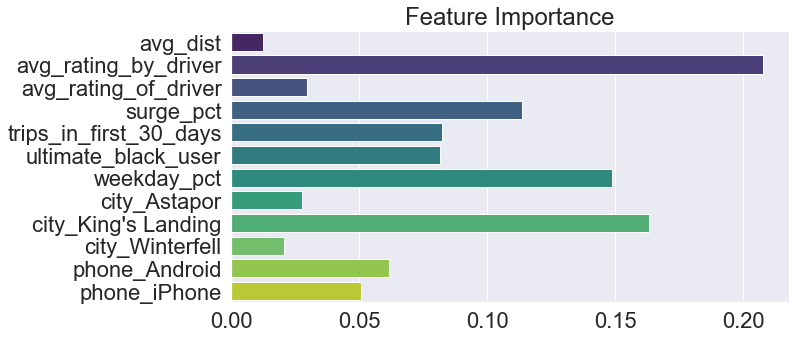

In [959]:
plt.figure(figsize=(10,5))
sns.barplot(x=classifier.feature_importances_, y=X.columns, palette='viridis')
plt.title('Feature Importance');

Rating by driver (of the user) appears to be a big influencer for retention, as well as King's Landing, weekday_percent, and surge_pct. 

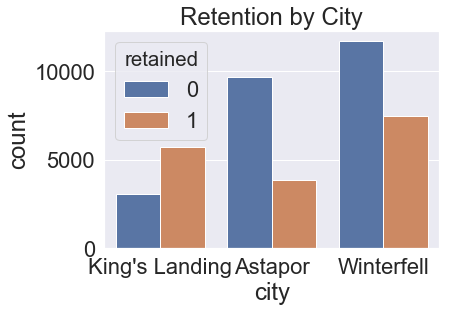

In [960]:
df['city'] = cities
sns.countplot(x=df.city, hue=df.retained)
plt.title('Retention by City');

## Suggestions:

Using this information a Ultimate may determine that user perceived satisfaction (by receiving 5 stars by the driver) could influence their return rate. Similarly, analyzing aspects of King's Landing that have caused rider retention well above the other two cities could be a key in bringing retention rate up. Riders who use during the week appear to be highly retained as well. Combining all this, giving discounts or perks to people who ride during the day, or in the other two cities could drastically improve rider retention.